## Subgroup B Question 3

How can we better allocate resources (staff, capacity) across different attractions and services to meet varying demand?
1. Develop a model to optimize resource allocation across the venue.
2. Incorporate factors such as peak hours, special events, and seasonal variations.

### Answering point 1
The resources for this question will be the total number of staff. For attractions that require a longer wait time, we allocate more resources (staff) to that attraction. More staff means they can perform shifts, work faster in processing guests, and cater to those waiting in the queue like providing snacks or drinks. This would help shorten wait time and increase guest satisfaction while they're queueing.

#### Modelling
The "model" in this case is not a typical machine learning model as they are mainly used for predictions, but our problem deals with Optimization. We instead use linear Optimization, as we want to optimise an objective given resource limitations. We will also consider a greedy approach to minimise wait time.

### Answering point 2
We will be making use of the predictions of guest flow and demand from Subgroup B Question 1 to optimize staff allocation for a certain day. The predictions incorporated factors like special events, seasonal variations and wait times from the previous day. This fits the needs of the requirements for point 2, excluding peak hours.

#### Factors
The predicted wait times is able to factor in most of the necessary factors like special events and seasonal variations, except for peak hours. Since we are utilising all staff that has been allocated to rides, like if 500 staff were allocated to handling rides, then all 500 of them will be allocated, instead of 250 or a lower number. It is therefore safe to assume that peak hours has been accounted for in our optimal allocation.

In [ ]:
import pandas as pd
from random import randint
import matplotlib.pyplot as plt
import pulp
import numpy as np

### Collated forecasts per ride

Subgroup B Question 1 has provided us with collated_forecasts_per_ride.csv, which is a forecast of the wait times for each ride for a specific day.

In [56]:
collated_forecasts_df = pd.read_csv('collated_forecasts_per_ride.csv')

### Choice of date

Since wait times vary by date, we pick a particular date to optimise staff allocation on. For now, we set it to be a random date in the data.

In [57]:
all_dates = collated_forecasts_df['date'].unique()
all_dates

array(['10/22/2024', '10/23/2024', '10/24/2024', '10/25/2024',
       '10/26/2024', '10/27/2024', '10/28/2024', '10/29/2024',
       '10/30/2024', '10/31/2024', '11/1/2024', '11/2/2024', '11/3/2024',
       '11/4/2024'], dtype=object)

Depending on the needs of the user, they can change the date to any date that has been forecasted.

In [58]:
date = all_dates[randint(0, all_dates.shape[0]-1)]
date

'10/27/2024'

### wait_times Dictionary 

This dictionary simply maps the attraction names to their forecasted wait time for the date we chose above. This allows us to handle the linear Optimization later easier.

The dictionary also has been sorted by the forecasted wait time in ascending order as we want to compare the bar plots of attractions vs. forecasted wait time and attractions vs. staff allocated to see if they would look similar.

In [59]:
forecasts_df = collated_forecasts_df[collated_forecasts_df['date'] == date]
wait_times = dict(sorted(zip(forecasts_df['attraction_name'], forecasts_df['forecast']), key = lambda x:x[1]))
wait_times

{'[The Lost World] Hatched! Featuring Dr. Rooney': 0.0,
 '[Far Far Away] Puss In Boots Giant Journey': 0.0,
 '[The Lost World] Raptor Encounter with Blue': 2.893439649,
 '[Sci-Fi City] Sci-Fi Games': 3.391210441,
 '[Hollywood] Trolls Hug Time Jubilee': 3.97457644,
 '[Far Far Away] Donkey Live': 4.293664447,
 '[Far Far Away] Magic Potion Spin': 5.483483658,
 '[The Lost World] WaterWorld': 9.512374114,
 '[Ancient Egypt] Treasure Hunters': 10.08792082,
 '[Far Far Away] Happily Ever After': 10.5080857,
 '[The Lost World] Dino-Soarin': 11.44146061,
 '[Sci-Fi City] TRANSFORMERS: Voices of Cybertron': 11.95474235,
 '[New York] Lights, Camera, Action!': 12.70931872,
 '[Sci-Fi City] Accelerator': 12.84930315,
 '[Far Far Away] Shrek 4-D Adventure': 16.15483679,
 '[New York] Sesame Street Spaghetti Chase': 19.2659425,
 '[The Lost World] Canopy Flyer': 21.05494734,
 '[Far Far Away] Enchanted Airways': 21.21844,
 '[Sci-Fi City] Battlestar Galatica: HUMAN vs CYLON': 25.15388975,
 '[The Lost World] J

In [60]:
attractions = list(wait_times.keys())
num_of_attractions = len(attractions)

forecasts = list(wait_times.values())

### Bar plot of Attractions vs. Forecasts

This allows us to see which rides require a higher wait time. It also allows us to verify later if the optimised answer would make sense.

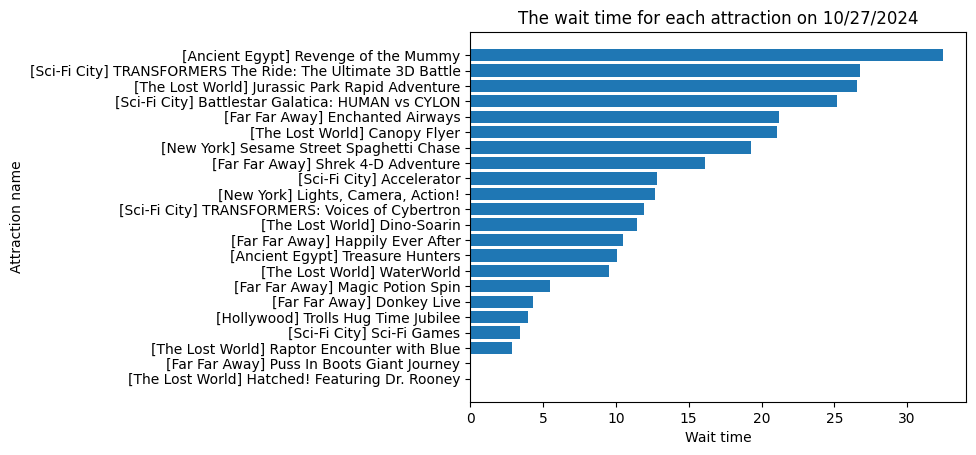

In [61]:
fig_forecast, ax_forecast = plt.subplots()
ax_forecast.barh(attractions, forecasts)
ax_forecast.set_xlabel("Wait time")
ax_forecast.set_ylabel("Attraction name")
ax_forecast.set_title(f"The wait time for each attraction on {date}")
plt.figure(fig_forecast)
plt.show()

### Staff numbers

total_staff refers to the total number of staff working on a particular day. It has been set to an arbitrary number. This number is subject to change depending on the actual number of staff working on a particular day.

min_staff_per_attraction refers to the minimum number of staff required at a ride. It has also been set to an arbitrary number. This number depends on the needs of USS.

In [62]:
total_staff = 500
min_staff_per_attraction = 5

### Mininum staffing checker

This part is for ensuring that the minimum staff per attraction is within bounds to ensure that the code will work.

In [63]:
if min_staff_per_attraction < 0:
    min_staff_per_attraction = 0
elif min_staff_per_attraction > total_staff//num_of_attractions+1:
    min_staff_per_attraction = min_staff_per_attraction//num_of_attractions
if total_staff < num_of_attractions:
    min_staff_per_attraction = 0

min_staff_per_attraction

5

## Linear Optimization

### Objective function
Our objective is to minimise the total deviation from the target or optimal allocation for each attraction. This can be represented as:
$$\text{Minimize } \sum_{i=1}^{n} d_i$$
where: 
- $d_i$: the deviation of the staff allocated from the target staff allocated for attraction $i$

### Constraints
Constraint 1: the sum of staff allocations across all attractions should not exceed the total number of staff available. This can be represented as:
$$\sum_{i=1}^{n} x_i \leqslant T$$
where:
- $x_i$: the number of staff allocated to attraction $i$
- $T$: the total number of staff available on the chosen date

Constraint 2: each ride must have at least the minimum number of required staff, as assigned by USS. This can be represented as:
$$x_i \geqslant m \quad \forall i \in {1,2,...,n}$$
where:
- $x_i$: the number of staff allocated to attraction $i$
- $m$: the minimum number of staff to be allocated per ride

Constraint 3: each ride's staff allocation needs to be close to its target proportional allocation, with some minor deviations. This can be represented as:
$$x_i = target_i + d_i$$
where:
- $x_i: the number of staff allocated to attraction $i$
- $d_i: the devation of the staff allocated from the target staff allocated for attraction $i$

In [64]:
# Problem setup
problem = pulp.LpProblem("Proportional_Staff_Allocation_Optimization", pulp.LpMinimize)

# Decision variables
staff_allocation = pulp.LpVariable.dicts("Staff", attractions, lowBound=min_staff_per_attraction, cat="Integer")
deviation = pulp.LpVariable.dicts("Deviation", attractions, lowBound=0, cat="Continuous")

# Objective function
problem += pulp.lpSum(deviation[attraction] for attraction in attractions)

# Constraint 1
problem += pulp.lpSum(staff_allocation[attraction] for attraction in attractions) <= total_staff, "TotalStaffConstraint"

# Constraint 2
for attraction in attractions:
    problem += staff_allocation[attraction] >= min_staff_per_attraction

# Constraint 3
for attraction in attractions:
    target_allocation = {attraction: int(total_staff * (wait / sum(forecasts))) for attraction, wait in wait_times.items()}[attraction]
    problem += staff_allocation[attraction] == target_allocation + deviation[attraction] - deviation.get(f"neg_{attraction}", 0)

### Solving the problem

If the output of this is 1, then there is a solution that linearly optimises the problem. Otherwise, if it is -1, then there is no solution that linearly optimises the problem.

In [65]:
problem.solve()

1

### Displaying the optimal staff allocation

The output comes from the linear Optimization problem as solved from above.

In [66]:
optimal_allocation_linear = {attraction: staff_allocation[attraction].varValue for attraction in attractions}
print("Optimal Staff Allocation:")
for attraction, staff in optimal_allocation_linear.items():
    print(f"{attraction}: {staff} staff")

Optimal Staff Allocation:
[The Lost World] Hatched! Featuring Dr. Rooney: 5.0 staff
[Far Far Away] Puss In Boots Giant Journey: 5.0 staff
[The Lost World] Raptor Encounter with Blue: 5.0 staff
[Sci-Fi City] Sci-Fi Games: 5.0 staff
[Hollywood] Trolls Hug Time Jubilee: 6.0 staff
[Far Far Away] Donkey Live: 7.0 staff
[Far Far Away] Magic Potion Spin: 9.0 staff
[The Lost World] WaterWorld: 16.0 staff
[Ancient Egypt] Treasure Hunters: 17.0 staff
[Far Far Away] Happily Ever After: 18.0 staff
[The Lost World] Dino-Soarin: 19.0 staff
[Sci-Fi City] TRANSFORMERS: Voices of Cybertron: 20.0 staff
[New York] Lights, Camera, Action!: 22.0 staff
[Sci-Fi City] Accelerator: 22.0 staff
[Far Far Away] Shrek 4-D Adventure: 28.0 staff
[New York] Sesame Street Spaghetti Chase: 33.0 staff
[The Lost World] Canopy Flyer: 36.0 staff
[Far Far Away] Enchanted Airways: 36.0 staff
[Sci-Fi City] Battlestar Galatica: HUMAN vs CYLON: 43.0 staff
[The Lost World] Jurassic Park Rapid Adventure: 46.0 staff
[Sci-Fi City] T

### Bar plot of Attractions vs. Staff allocations

This allows us to see which rides require a higher number of staff to be allocated. 

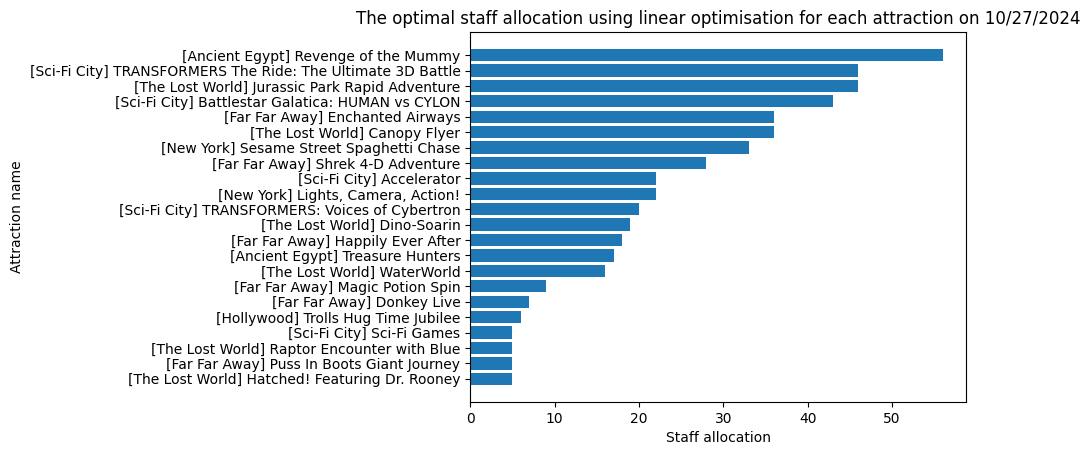

In [ ]:
fig_linear, ax_linear = plt.subplots()
ax_linear.barh(optimal_allocation_linear.keys(), optimal_allocation_linear.values())
ax_linear.set_xlabel("Staff allocation")
ax_linear.set_ylabel("Attraction name")
ax_linear.set_title(f"The optimal staff allocation using linear Optimization for each attraction on {date}")
plt.figure(fig_linear)
plt.show()

### Linear Optimization Conclusion

As can be seen from above, the two bar plots of attraction vs. wait time and attraction vs. staff allocation are very similar. 

This gives us some interpretation of the solution generated from the linear Optimization model. It would make sense that an attraction that has a higher waiting time would need more staff allocated to it. This would result in a proportionate output where the staff allocations are proportionally equal to the waiting times for all the attractions.

So, the output is trivial in a sense as it can already be derived just from looking at the first bar plot without the need for the linear Optimization model.

## Greedy Heuristic

Rather than viewing the problem as minimising the total deviation from the target allocation, we can instead view it more simply as minimising the wait times, if we assume that allocating 1 staff to an attraction would reduce the wait time. 

We can view our new problem as a non-linear Optimization problem, but taking a greedy approach is much simpler to understand and interpret. It is greedy as we are always allocating staff to the attraction that requires the highest time.

### Wait time

The wait time for each attraction $i$ after allocating $x_i$ staff can be represented as:
$$\text{adjusted\_wait\_time}_i = w_i \times \text{reduction\_factor}^{x_i - m}$$
where:
- $\text{reduction\_factor}$: each additional staff reduces the wait time by a factor, if $w_i=100 and $\text{reduction\_factor}=0.9$, then having 1 additional staff would mean $\text{adjusted\_wait\_time}_i=100*0.9^{6-5}=90$
- $w_i$: wait time for attraction $i$
- $m$: the minimum number of staff to be allocated per ride

### Total wait time

Using the previous adjusted wait time function, the total wait time after adjustment can be represented as:
$$\text{Total wait time} = \sum_{i=1}^n \text{adjusted\_wait\_time}_i = \sum_{i=1}^{n} w_i \times \text{reduction\_factor}^{x_i - m}$$

### Objective function
Our objective is to minimise the total adjusted wait time. This can be represented as:
$$\text{Minimize } \sum_{i=1}^{n} w_i \times \text{reduction\_factor}^{x_i - m}$$

### Constraints
Constraint 1: the sum of staff allocations across all attractions should not exceed the total number of staff available. This can be represented as:
$$\sum_{i=1}^{n} x_i \leqslant T$$
where:
- $x_i$: the number of staff allocated to attraction $i$
- $T$: the total number of staff available on the chosen date

Constraint 2: each ride must have at least the minimum number of required staff, as assigned by USS. This can be represented as:
$$x_i \geqslant m \quad \forall i \in {1,2,...,n}$$
where:
- $x_i$: the number of staff allocated to attraction $i$
- $m$: the minimum number of staff to be allocated per ride

In [68]:
reduction_factor = 0.95

# make a copy of wait_times as we need to make changes to the wait times
temp_wait_times = list(wait_times.copy().items())

# we start each attraction with the minimum staff per attraction, satisfying constraint 2
optimal_allocation_greedy = {attraction:min_staff_per_attraction for attraction in attractions}

# we add 1 staff per iteration of the loop
# and ensure that we don't exceed T number of staff
# this satisfies constraint 1
for _ in range(total_staff - min_staff_per_attraction*num_of_attractions):

    # set initial variables to be nothing
    attraction = ''
    wait_time = -1
    index = -1

    # we find the attraction with the highest wait time, as we are doing greedy approach
    for j in range(len(temp_wait_times)):
        if temp_wait_times[j][1] > wait_time:
            attraction = temp_wait_times[j][0]
            wait_time = temp_wait_times[j][1]
            index = j

    # we set temp_wait_times[index] to be the new adjusted wait time after reduction
    # this is our objective function but simplifed as we are doing it iteratively
    temp_wait_times[index] = (attraction, wait_time * reduction_factor)
    optimal_allocation_greedy[attraction] += 1

### Displaying the optimal staff allocation

The output comes from the linear Optimization problem as solved from above.

In [69]:
print("Optimal Staff Allocation:")
for attraction, staff in optimal_allocation_greedy.items():
    print(f"{attraction}: {staff} staff")

Optimal Staff Allocation:
[The Lost World] Hatched! Featuring Dr. Rooney: 5 staff
[Far Far Away] Puss In Boots Giant Journey: 5 staff
[The Lost World] Raptor Encounter with Blue: 5 staff
[Sci-Fi City] Sci-Fi Games: 5 staff
[Hollywood] Trolls Hug Time Jubilee: 5 staff
[Far Far Away] Donkey Live: 5 staff
[Far Far Away] Magic Potion Spin: 9 staff
[The Lost World] WaterWorld: 20 staff
[Ancient Egypt] Treasure Hunters: 21 staff
[Far Far Away] Happily Ever After: 22 staff
[The Lost World] Dino-Soarin: 24 staff
[Sci-Fi City] TRANSFORMERS: Voices of Cybertron: 24 staff
[New York] Lights, Camera, Action!: 26 staff
[Sci-Fi City] Accelerator: 26 staff
[Far Far Away] Shrek 4-D Adventure: 30 staff
[New York] Sesame Street Spaghetti Chase: 34 staff
[The Lost World] Canopy Flyer: 35 staff
[Far Far Away] Enchanted Airways: 36 staff
[Sci-Fi City] Battlestar Galatica: HUMAN vs CYLON: 39 staff
[The Lost World] Jurassic Park Rapid Adventure: 40 staff
[Sci-Fi City] TRANSFORMERS The Ride: The Ultimate 3D Ba

### Bar plot of Attractions vs. Staff allocations

This allows us to see which rides require a higher number of staff to be allocated. 

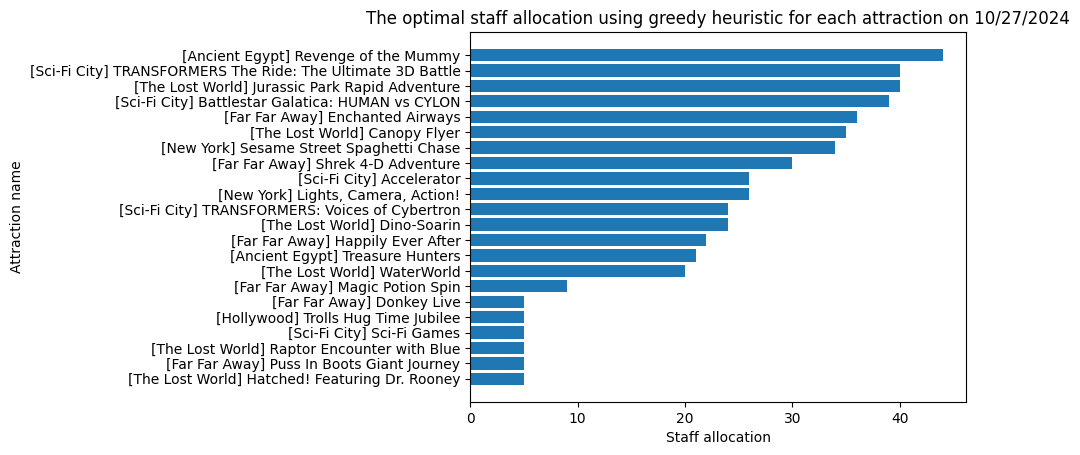

In [70]:
fig_greedy, ax_greedy = plt.subplots()
ax_greedy.barh(optimal_allocation_greedy.keys(), optimal_allocation_greedy.values())
ax_greedy.set_xlabel("Staff allocation")
ax_greedy.set_ylabel("Attraction name")
ax_greedy.set_title(f"The optimal staff allocation using greedy heuristic for each attraction on {date}")
plt.figure(fig_greedy)
plt.show()

### Greedy Heuristic Conclusion

The attraction vs. staff allocation bar plot looks less similar in terms of proportionality to the attraction vs. wait times bar plot.

Since we are trying to minimise total wait time, it makes sense that the ride with the highest wait time would be prioritised to have more staff allocated to it. However, this time we allocate more in proportion to the rest of the rides. In a sense, it is slightly more uniform and less one-sided.

We can present two different solutions to optimise the staff allocation for rides for a particular day. The relevant stakeholder can then pick the solution that they think makes more sense. This multi-faceted approach allows for a more flexible solution.

## Visualisations

This is to allow for easier comparison of the different plots. In order, the plots are:
1. Attraction vs. wait time
2. Attraction vs. optimal staff allocation (linear solution)
3. Attraction vs. optimal staff allocation (greedy solution)

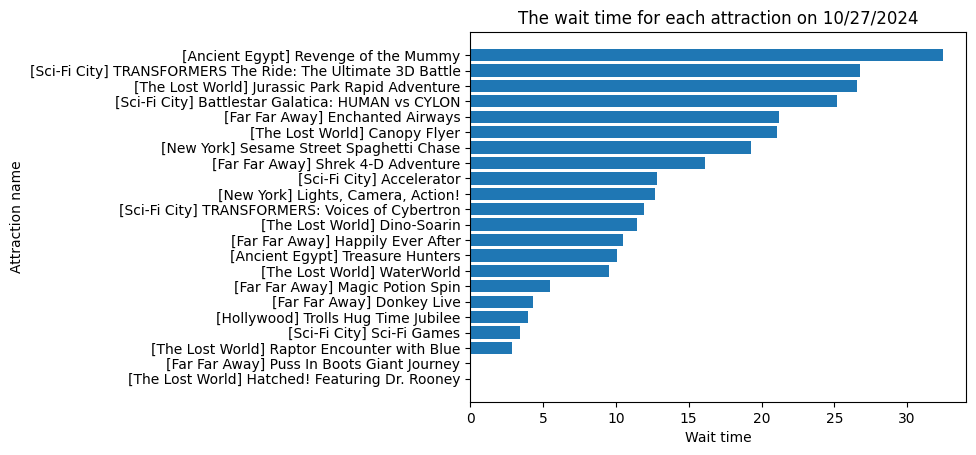

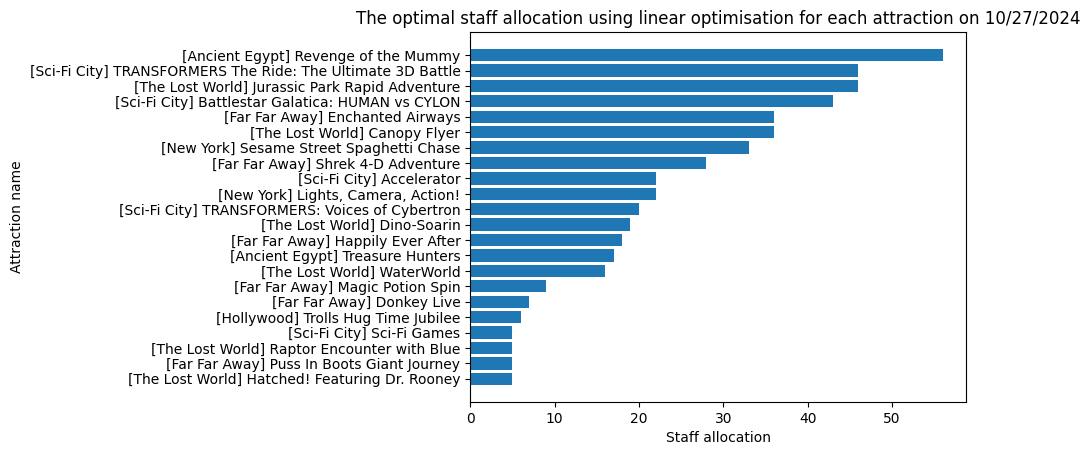

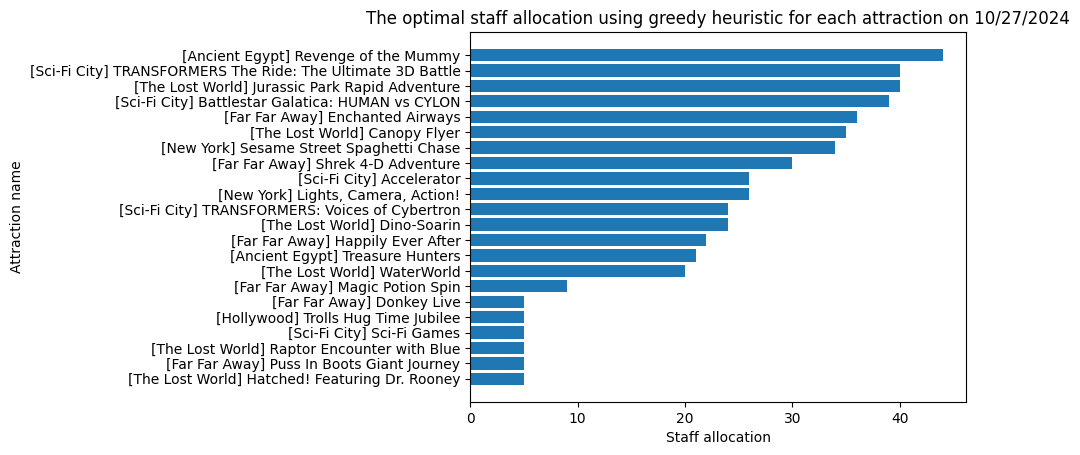

In [71]:
plt.figure(fig_forecast)
plt.show()

plt.figure(fig_linear)
plt.show()

plt.figure(fig_greedy)
plt.show()

### Visual comparison of optimal allocation

The explanations for the bar plots can be found above in:
- Linear Optimization Conclusion
- Greedy Heuristic Conclusion

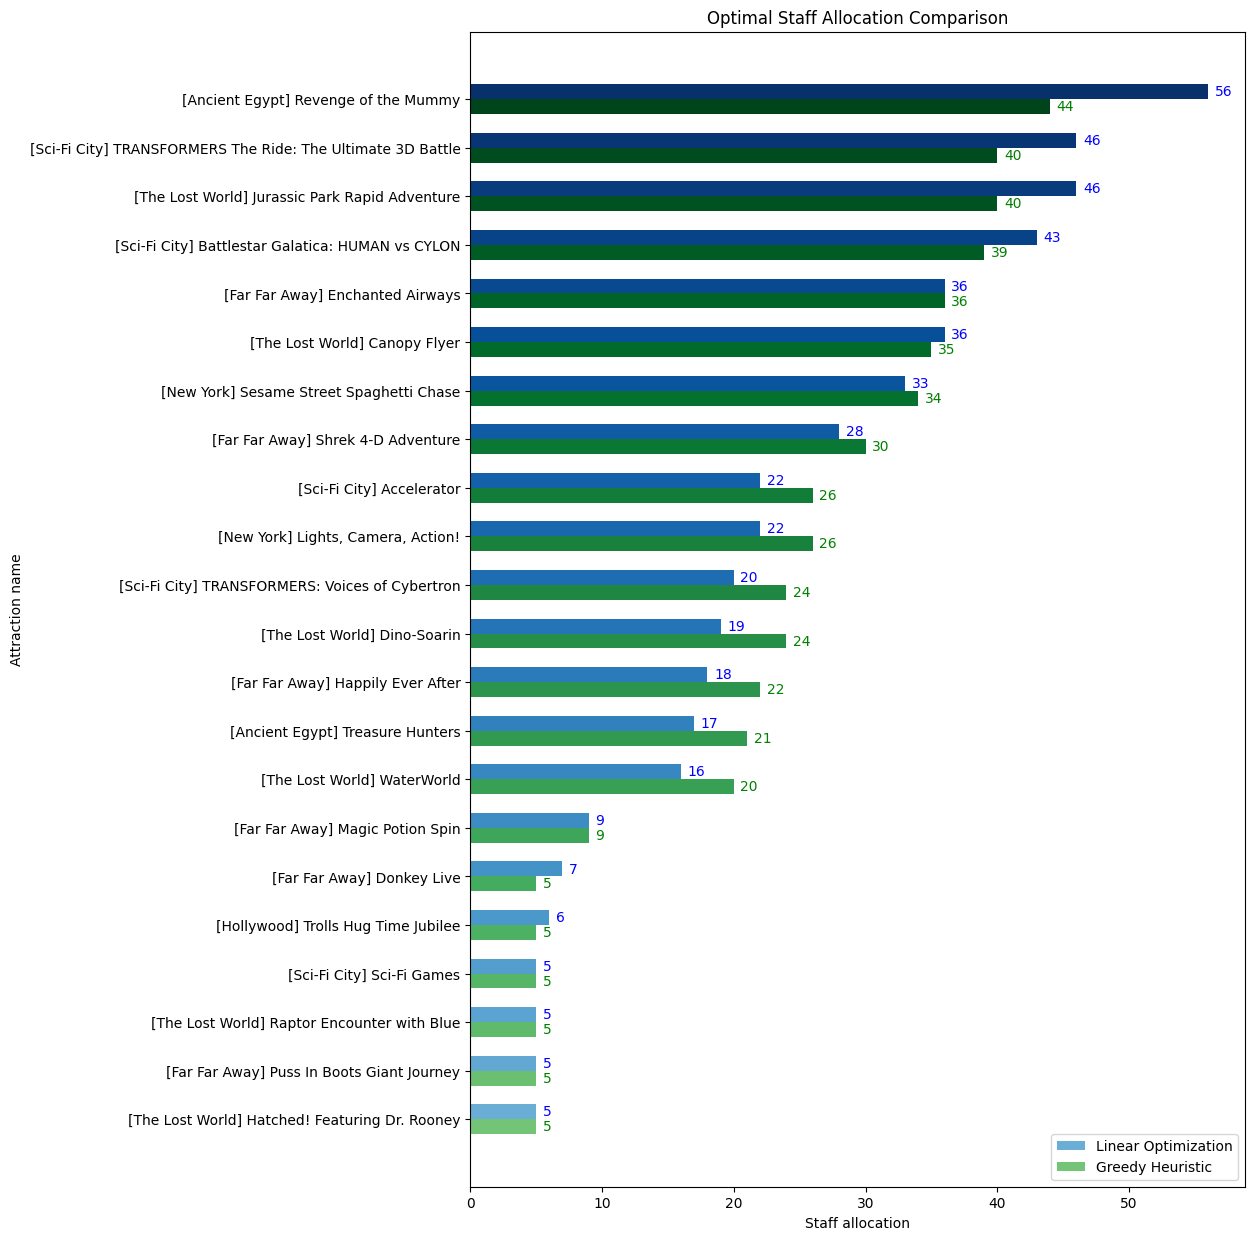

In [77]:
y_pos = np.arange(len(attractions)) * 1.3

staff_linear = list(optimal_allocation_linear.values())
staff_greedy = list(optimal_allocation_greedy.values())

fig, ax = plt.subplots(figsize=(10, 15))

blue_colors = plt.cm.Blues(np.linspace(0.5, 1, len(staff_linear)))
green_colors = plt.cm.Greens(np.linspace(0.5, 1, len(staff_greedy)))

for i in range(len(staff_linear)):
    ax.barh(y_pos[i] + 0.2, staff_linear[i], height=0.4, color=blue_colors[i], label='Linear Optimization' if i == 0 else "")
    ax.barh(y_pos[i] - 0.2, staff_greedy[i], height=0.4, color=green_colors[i], label='Greedy Heuristic' if i == 0 else "")

for i, v in enumerate(staff_linear):
    ax.text(v + 0.5, y_pos[i] + 0.2, str(int(v)), color='blue', va='center')
for i, v in enumerate(staff_greedy):
    ax.text(v + 0.5, y_pos[i] - 0.2, str(int(v)), color='green', va='center')

ax.set_yticks(y_pos)
ax.set_yticklabels(attractions)
ax.set_xlabel("Staff allocation")
ax.set_ylabel("Attraction name")
ax.set_title("Optimal Staff Allocation Comparison")

ax.legend()

plt.savefig('staff_allocation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()